1

In [4]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# بارگذاری دیتاست آموزش
df_train = pd.read_csv("E:/Erfan/Fundamental intelligent systems/Final project/loan_train.csv")

# بارگذاری دیتاست تست
df_test = pd.read_csv("E:/Erfan/Fundamental intelligent systems/Final project/loan_test.csv")

# حذف تمام مقادیر NaN از هر دو دیتاست
df_train = df_train.dropna()
df_test = df_test.dropna()

# ستون‌های اسمی که باید عددی شوند
cat_cols = ["Gender", "Married", "Education", "Self_Employed", "Area", "Status"]

# Label Encoding برای هر دو دیتاست
le = LabelEncoder()
for col in cat_cols:
    if col in df_train.columns:
        df_train[col] = le.fit_transform(df_train[col])
    if col in df_test.columns:
        df_test[col] = le.transform(df_test[col])  # استفاده از fit_transform برای دیتاست تست غیرممکن است

# تقسیم داده‌های آموزش
X_train = df_train.drop('Status', axis=1)  # ستون هدف تغییر کرده است
y_train = df_train['Status']

# برای دیتاست تست، فقط ویژگی‌ها (X_test) را استفاده می‌کنیم
X_test = df_test.drop('Status', axis=1, errors='ignore')  # اگر ستون 'Status' موجود نباشد، هیچ مشکلی پیش نمی‌آید

# تقسیم داده‌های آموزش و تست به نسبت 70% آموزش و 30% تست
X_train, X_test, y_train, _ = train_test_split(X_train, y_train, test_size=0.3, random_state=73)

# نمایش اطلاعات مربوط به داده‌های آموزش و تست
print(f"Training data size: {X_train.shape}")
print(f"Test data size: {X_test.shape}")


Training data size: (349, 11)
Test data size: (150, 11)


1b

In [11]:
import numpy as np
import pyswarms as ps
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# جدا کردن X و y
from sklearn.preprocessing import LabelEncoder

df = df_train.dropna().copy()

for col in df.columns:
    if df[col].dtype == "object":
        df[col] = LabelEncoder().fit_transform(df[col].astype(str))

X = df.drop(columns=["Status"]).values
y = df["Status"].values

n_features = X.shape[1]
alpha = 0.7

# تابع برازندگی
def fitness_function(particles):
    costs = np.zeros(particles.shape[0])
    model = RandomForestClassifier(n_estimators=50, random_state=42)

    for i, p in enumerate(particles):
        mask = p.astype(bool)

        if mask.sum() == 0:
            costs[i] = 1
            continue

        X_sel = X[:, mask]
        acc = cross_val_score(model, X_sel, y, cv=5, scoring="accuracy").mean()

        J = alpha * (1 - acc) + (1 - alpha) * (1 - mask.sum() / n_features)
        costs[i] = J

    return costs

# تنظیم PSO باینری
options = {
    "c1": 0.5,
    "c2": 0.9,
    "w": 0.3,
    "k": 5,
    "p": 2
}


optimizer = ps.discrete.BinaryPSO(
    n_particles=20,
    dimensions=n_features,
    options=options
)

# اجرای PSO
best_cost, best_pos = optimizer.optimize(fitness_function, iters=50)

# ویژگی‌های منتخب
selected_features = df.drop(columns=["Status"]).columns[best_pos.astype(bool)]
print(list(selected_features))


2026-02-02 00:18:37,075 - pyswarms.discrete.binary - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.9, 'w': 0.3, 'k': 5, 'p': 2}
pyswarms.discrete.binary:   0%|          |0/50

pyswarms.discrete.binary: 100%|██████████|50/50, best_cost=0.203
2026-02-02 00:27:47,204 - pyswarms.discrete.binary - INFO - Optimization finished | best cost: 0.20321414141414143, best pos: [1 1 1 0 1 1 1 1 0 1 1]


['Gender', 'Married', 'Dependents', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Credit_History', 'Area']


g

In [12]:
import random
import numpy as np
from deap import base, creator, tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

X = df.drop(columns=["Status"]).values
y = df["Status"].values
n_features = X.shape[1]

alpha = 0.7
RF_TREES = 80
CV = 3

# ---------- Fitness (کمینه‌سازی J) ----------
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

eval_cache = {}

def eval_individual(ind):
    key = tuple(ind)
    if key in eval_cache:
        return eval_cache[key]

    mask = np.array(ind, dtype=bool)
    if mask.sum() == 0:
        J = 1.0
    else:
        model = RandomForestClassifier(n_estimators=RF_TREES, random_state=42, n_jobs=-1)
        acc = cross_val_score(model, X[:, mask], y, cv=CV, scoring="accuracy", n_jobs=-1).mean()
        J = alpha * (1 - acc) + (1 - alpha) * (1 - mask.sum() / n_features)

    eval_cache[key] = (J,)
    return (J,)

toolbox.register("evaluate", eval_individual)
toolbox.register("mate", tools.cxTwoPoint)                 # Two-Point Crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)   # Bit Flip Mutation
toolbox.register("select", tools.selTournament, tournsize=3)

# ---------- اجرای GA ----------
pop = toolbox.population(n=30)
NGEN, CXPB, MUTPB = 50, 0.9, 0.1

for _ in range(NGEN):
    invalid = [ind for ind in pop if not ind.fitness.valid]
    for ind in invalid:
        ind.fitness.values = toolbox.evaluate(ind)

    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for c1, c2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(c1, c2)
            del c1.fitness.values, c2.fitness.values

    for mut in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(mut)
            del mut.fitness.values

    pop[:] = offspring

best = tools.selBest(pop, 1)[0]
best_cost = best.fitness.values[0]
selected_features = df.drop(columns=["Status"]).columns[np.array(best, dtype=bool)]

print("best_cost =", best_cost)
print(list(selected_features))


best_cost = 0.1641127383786643
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term', 'Credit_History', 'Area']


d

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

pso_features = list(selected_features)
ga_features = list(selected_features)


X = df.drop(columns=["Status"])
y = df["Status"]

def evaluate(features):
    model = RandomForestClassifier(n_estimators=80, random_state=42)
    acc = cross_val_score(model, X[features], y, cv=5, scoring="accuracy").mean()
    return acc, len(features)

pso_acc, pso_n = evaluate(pso_features)
ga_acc, ga_n = evaluate(ga_features)

print("PSO : Accuracy:", pso_acc, " Features:", pso_n)
print("GA  : Accuracy:", ga_acc,  " Features:", ga_n)


PSO : Accuracy: 0.7955757575757575  Features: 11
GA  : Accuracy: 0.7955757575757575  Features: 11


h

In [5]:
print("Important features selected by PSO:")
print(pso_features)

print("\nImportant features selected by GA:")
print(ga_features)


Important features selected by PSO:
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term', 'Credit_History', 'Area']

Important features selected by GA:
['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Applicant_Income', 'Coapplicant_Income', 'Loan_Amount', 'Term', 'Credit_History', 'Area']


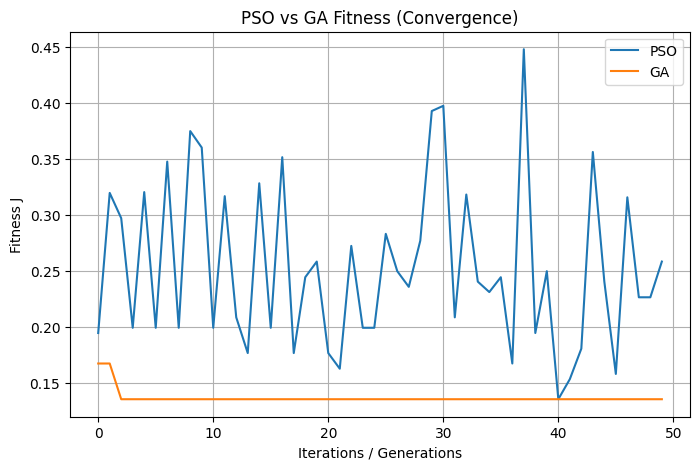

In [6]:
# --- Section (و): PSO vs GA convergence plot (Fitness J over iterations/generations) ---

import random
import numpy as np
import matplotlib.pyplot as plt

import pyswarms as ps
from deap import base, creator, tools

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

# ---------- Data ----------
X = df.drop(columns=["Status"]).values
y = df["Status"].values
n_features = X.shape[1]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

alpha = 0.7
RF_TREES = 80

# ===================== PSO =====================
pso_cost_history = []

def pso_fitness(particles):
    costs = np.zeros(particles.shape[0])
    model = RandomForestClassifier(n_estimators=RF_TREES, random_state=42, n_jobs=-1)

    for i, p in enumerate(particles):
        mask = p.astype(bool)
        if mask.sum() == 0:
            costs[i] = 1.0
            continue

        model.fit(X_train[:, mask], y_train)
        acc = accuracy_score(y_test, model.predict(X_test[:, mask]))
        costs[i] = alpha * (1 - acc) + (1 - alpha) * (1 - mask.sum() / n_features)

    pso_cost_history.append(costs.min())
    return costs

pso_options = {"c1": 0.5, "c2": 0.3, "w": 0.9, "k": 5, "p": 2}  # اگر خواستی تغییر بده
pso_particles = 20
pso_iters = 50

pso_opt = ps.discrete.BinaryPSO(n_particles=pso_particles, dimensions=n_features, options=pso_options)
pso_best_cost, pso_best_pos = pso_opt.optimize(pso_fitness, iters=pso_iters, verbose=False)

# ===================== GA =====================
ga_cost_history = []

try:
    creator.FitnessMin
except AttributeError:
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
try:
    creator.Individual
except AttributeError:
    creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=n_features)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

eval_cache = {}

def ga_eval(ind):
    key = tuple(ind)
    if key in eval_cache:
        return eval_cache[key]

    mask = np.array(ind, dtype=bool)
    if mask.sum() == 0:
        J = 1.0
    else:
        model = RandomForestClassifier(n_estimators=RF_TREES, random_state=42, n_jobs=-1)
        model.fit(X_train[:, mask], y_train)
        acc = accuracy_score(y_test, model.predict(X_test[:, mask]))
        J = alpha * (1 - acc) + (1 - alpha) * (1 - mask.sum() / n_features)

    eval_cache[key] = (J,)
    return (J,)

toolbox.register("evaluate", ga_eval)
toolbox.register("mate", tools.cxTwoPoint)                 # Two-Point Crossover
toolbox.register("mutate", tools.mutFlipBit, indpb=0.1)    # Bit Flip Mutation
toolbox.register("select", tools.selTournament, tournsize=3)

POP = 50
NGEN = 50
CXPB = 0.9
MUTPB = 0.1

pop = toolbox.population(n=POP)

for _ in range(NGEN):
    invalid = [ind for ind in pop if not ind.fitness.valid]
    for ind in invalid:
        ind.fitness.values = toolbox.evaluate(ind)

    best = tools.selBest(pop, 1)[0]
    ga_cost_history.append(best.fitness.values[0])

    offspring = toolbox.select(pop, len(pop))
    offspring = list(map(toolbox.clone, offspring))

    for c1, c2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < CXPB:
            toolbox.mate(c1, c2)
            del c1.fitness.values, c2.fitness.values

    for m in offspring:
        if random.random() < MUTPB:
            toolbox.mutate(m)
            del m.fitness.values

    pop[:] = offspring

# ===================== Plot =====================
plt.figure(figsize=(8, 5))
plt.plot(pso_cost_history, label="PSO")
plt.plot(ga_cost_history, label="GA")
plt.xlabel("Iterations / Generations")
plt.ylabel("Fitness J")
plt.title("PSO vs GA Fitness (Convergence)")
plt.legend()
plt.grid(True)
plt.show()
